In [1]:
import warnings
warnings.filterwarnings('ignore')

# Module 12 Lab - Distance Based Machine Learning

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

We're getting to the point in the semester where you should be know the drill.

This module covered 3 basic problems: supervised learning (classification, regression), unsupervised learning (clustering) and recommenders (collaborative filtering based systems related to missing value imputation) using distance/similarity. We're only going to cover the first 2 in this lab.

You should definitely use [Scikit Learn](http://scikit-learn.org/stable/) and refer to the documentation for this assignment.

Remember to create a new random seed for each experiment (if needed) and save it.

**Problem 1. kNN Regression**

Use k-Nearest Neighbors *regression* for the insurance data set. Make sure you do the following:

1. Pick an appropriate evaluation metric.
2. Validation curves to find the best value of k.
3. Learning curves to see if we are high bias or high variance and suggest ways to improve the model.
4. 10 fold cross validation to estimate the mean metric and its credible interval.
5. Was this better than the best linear regression model you estimated in Lab 11? Use Bayesian statistical inference to generate and evaluate the posterior distribution of the difference of means.

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn
import models
import math
from sklearn import neighbors
import sklearn.linear_model as linear
from sklearn.cluster import KMeans
from numpy.random import rand

sns.set(style="whitegrid")
# load whatever other libraries you need including models.py

In [3]:
#from the book
def log( x):
    return np.log(float( x))

In [4]:
insurance = pd.read_csv("insurance.csv")

In [5]:
#transformations
region = pd.get_dummies(insurance["region"])
insurance["NE"] = region["northeast"]
insurance["NW"] = region["northwest"]
insurance["SE"] = region["southeast"]
insurance["log_charges"] = insurance["charges"].apply(log)

In [6]:
insurance["sex"] = insurance.sex.apply(lambda x: 1 if x == 'male' else 0)

In [7]:
insurance["smoker"] = insurance.smoker.apply(lambda x: 1 if x == 'yes' else 0)

In [8]:
#taken from a combo in: https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame/48651066
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name == "age" or feature_name == "bmi" or feature_name == "children" or feature_name == "log_charges":
            mean = df[feature_name].mean()
            std = df[feature_name].std()
            result[feature_name]=(df[feature_name]-mean)/std
    return result

In [9]:
#region and charges aren't needed anymore
insurance = insurance.drop(columns="region")
insurance = insurance.drop(columns="charges")

In [10]:
#The data must be normalized to be able to properly compare the values
insuranceNormal = normalize(insurance)

1. I will use MSE to measure how well the models perform.

Set up the model with a k of 3 to test using a uniform distance weight.

In [11]:
knn = neighbors.KNeighborsRegressor(3, 'uniform')
knn.fit(insuranceNormal.loc[:, insuranceNormal.columns != 'log_charges'],insuranceNormal['log_charges'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=3, p=2,
          weights='uniform')

In [12]:
knn.predict(insuranceNormal.loc[:, insuranceNormal.columns != 'log_charges'])

array([ 0.94799325, -0.78234266, -0.62450563, ..., -1.06798168,
       -1.65147512,  1.28460194])

2. Validation Curves to find the best k

In [13]:
def validation_curves( ks, data, iterations=100, test_size=0.2):
    train = []
    test = []
    for k in ks:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            train_mse, test_mse = cross_validate( k, data, test_size=test_size)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    print(train)
    print(test)
    return train, test

In [14]:
def mse( errors):
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)

In [15]:
from copy import deepcopy

def cross_validate( k, data, test_size=0.20):
    training_mses = []
    test_mses = []
    
    n = data.shape[ 0]
    test_n = int( np.round( test_size * n, 0))

    indices = deepcopy( data.index).values
    random.shuffle( indices)

    test_indices = indices[ 0:test_n]
    training_indices = indices[test_n:]

    test_set = data.ix[ test_indices]
    training_set = data.ix[ training_indices]
    
    y = training_set['log_charges']
    X = training_set.loc[:, training_set.columns != 'log_charges']
    model = neighbors.KNeighborsRegressor(k, 'uniform').fit(X,y)
    y_hat = model.predict( X)

    training_mse = mse( y - y_hat)
    
    y = test_set['log_charges']
    X = test_set.loc[:, test_set.columns != 'log_charges']
    y_hat = model.predict( X)

    test_mse = mse( y - y_hat)

    return training_mse, test_mse

In [16]:
# create the ks array to test with the validation curves.
ks = [i for i in range(1,16)]

In [17]:
train, test = validation_curves(ks, insuranceNormal)

[0.0740313441064929, 0.3132501178020966, 0.37062005143257215, 0.4052115773425954, 0.42687223524347706, 0.44497193255979234, 0.4583938505233369, 0.4717991690229595, 0.48445488741677745, 0.4956648844366751, 0.5027128784514444, 0.5114587800878319, 0.5186655260028853, 0.5239001509382477, 0.528509968913167]
[0.6211270164964083, 0.5527676575512757, 0.5417781705658162, 0.5316250459989899, 0.5296640091152577, 0.5358833835993415, 0.5389111493486687, 0.5432010736435562, 0.5512115120501777, 0.5545523993057894, 0.5640080118986657, 0.5656354567323391, 0.5667090866715272, 0.5698776248528852, 0.5738929073612445]


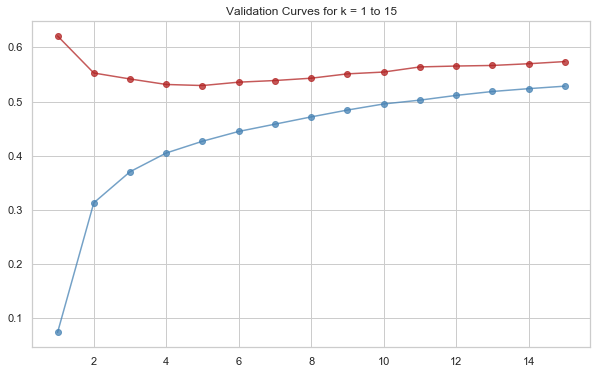

In [19]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( ks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( ks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Validation Curves for k = 1 to 15")

plt.show()
plt.close()

Based off of the above chart the lowest the test data goes is on k = 5 and there is not as much variance or bias as the other ks as well. I believe k=5 to be the best k value for this data set.

3. Learning curves

In [20]:
def learning_curve( k, data, increment=0.05, iterations=100, test_size=0.20):
    increments = int( 1.0/increment)
    chunks = [ int(x) for x in np.linspace( 0, data.shape[ 0], increments)][ 1:]
    train = []
    test = []
    for chunk in chunks:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            indices = list(range( data.shape[ 0]))
            random.shuffle( indices)
            chunk_indices = indices[0:chunk]
            data_chunk = data.ix[ chunk_indices]
            train_mse, test_mse = cross_validate( k, data_chunk, test_size=test_size)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    return chunks, train, test

I will use a k value of 5 since the validation curve pointed me in that direction.

In [21]:
chunks, train, test = learning_curve( 5, insuranceNormal, increment=0.01)

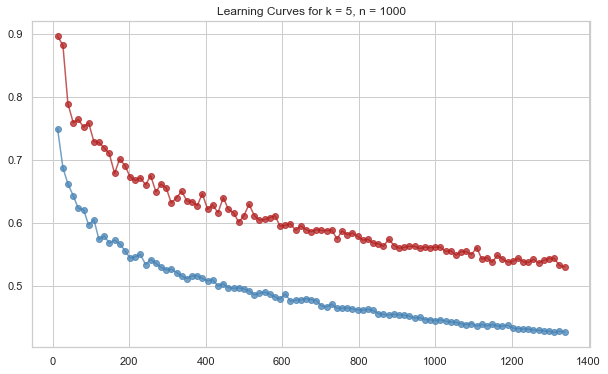

In [22]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for k = 5, n = 1000")


plt.show()
plt.close()

Since these are not coverging should I use a different k because the variance is too high? What does 6 and 7 look like?

In [23]:
chunks, train, test = learning_curve( 6, insuranceNormal, increment=0.01)

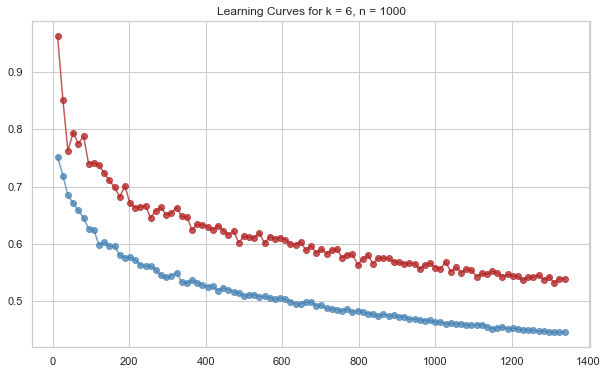

In [24]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for k = 6, n = 1000")


plt.show()
plt.close()

In [25]:
chunks, train, test = learning_curve( 7, insuranceNormal, increment=0.01)

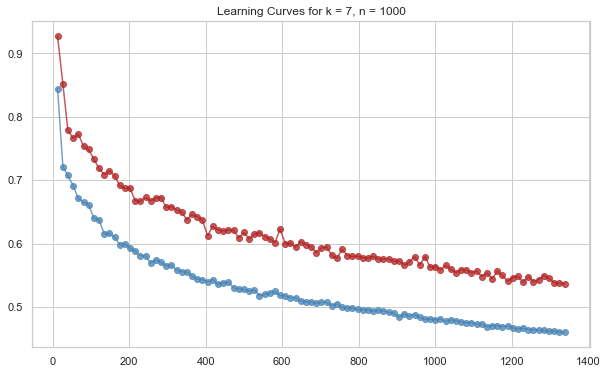

In [26]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for k = 7, n = 1000")


plt.show()
plt.close()

They get closer with each k it seems. I will test at 10 as well.

In [27]:
chunks, train, test = learning_curve( 10, insuranceNormal, increment=0.01)

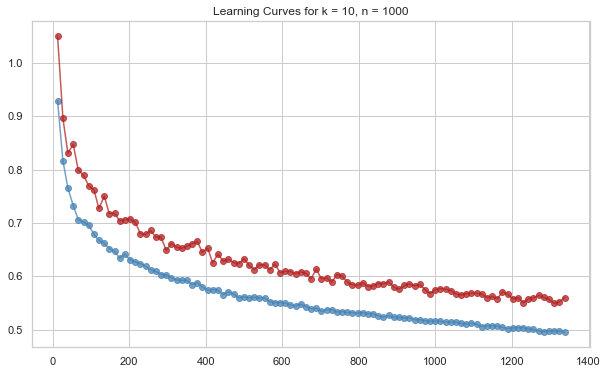

In [28]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for k = 10, n = 1000")


plt.show()
plt.close()

They are closer together overall but there still is no convergence. Because of this I still believe 5 is the best k. But more data may be necessary for this model as the variance is still too high. 

4. 10 Fold Validation

In [29]:
np.random.seed(26091985)

In [30]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [31]:
def tenfoldcross(data, k):
    np.random.shuffle(data.values)
    length = len(data)
    foldLength = int(length/10 + 1)
    folds = []
    mses = []
    
    #create folds
    for i in range(0, 10):
        fold = data[foldLength*(i):foldLength*(i+1)]
        folds.append(pd.DataFrame(fold))
    
    #run regression on each set of folds
    for i in range(0, 10):
        test = folds[i]
        if i == 0:
            dataset = pd.concat(folds[1:10])
        elif i == 9:
            dataset = pd.concat(folds[0:i])
        else:
            dataset1 = pd.concat(folds[0:i])
            dataset2 = pd.concat(folds[i+1:10])
            dataset = pd.concat([dataset1,dataset2])
        
        y = dataset['log_charges']
        X = dataset.loc[:, dataset.columns != 'log_charges']
        model = neighbors.KNeighborsRegressor(k, 'uniform').fit(X,y)
        y_hat = model.predict( X)

        mse_var = mse( y - y_hat)
        mses.append(mse_var)
        
    print("The mean squared error is:", np.mean(mses))    
    
    posteriorMSq = bootstrap_sample(mses, np.mean, 100)

    print("The 95% confidence interval for the MSE is: ", stats.mstats.mquantiles(posteriorMSq, [0.025, 0.975]))
    
    return posteriorMSq

In [32]:
posteriorKnn = tenfoldcross(insuranceNormal, 5)

The mean squared error is: 0.4201621800286075
The 95% confidence interval for the MSE is:  [0.41611848 0.42576632]


5. We can get the MSE from the linear regression model I had.

In [33]:
np.random.seed(98526091)

In [34]:
def linregtenfoldcross(data, model):
    np.random.shuffle(data.values)
    length = len(data)
    foldLength = int(length/10 + 1)
    folds = []
    mses = []

    
    #create folds
    for i in range(0, 10):
        fold = data[foldLength*(i):foldLength*(i+1)]
        folds.append(pd.DataFrame(fold))
    
    #run regression on each set of folds
    for i in range(0, 10):
        test = folds[i]
        if i == 0:
            dataset = pd.concat(folds[1:10])
        elif i == 9:
            dataset = pd.concat(folds[0:i])
        else:
            dataset1 = pd.concat(folds[0:i])
            dataset2 = pd.concat(folds[i+1:10])
            dataset = pd.concat([dataset1,dataset2])
        
        y = dataset['log_charges']
        X = dataset.loc[:, dataset.columns != 'log_charges']
        model = linear.LinearRegression( fit_intercept=False).fit( X, y)
        y_hat = model.predict( X)
        
        mse_var = mse( y - y_hat)
        mses.append(mse_var)
        
    print("The mean squared error is:", np.mean(mses))    
    
    posteriorMSq = bootstrap_sample(mses, np.mean, 100)

    print("The 95% confidence interval for the MSE is: ", stats.mstats.mquantiles(posteriorMSq, [0.025, 0.975]))

    return posteriorMSq

In [35]:
formula = "log_charges ~ age + bmi + children + smoker + NE + NW + SE"
posteriorLinear = linregtenfoldcross(insuranceNormal, formula)

The mean squared error is: 0.5045971557563913
The 95% confidence interval for the MSE is:  [0.50134845 0.50759821]


In [36]:
posteriorDiff = posteriorLinear - posteriorKnn

In [37]:
confLinear = stats.mstats.mquantiles( posteriorLinear, [0.05, 0.95])
confKnn = stats.mstats.mquantiles( posteriorKnn, [0.05, 0.95])
confDiff = stats.mstats.mquantiles( posteriorDiff, [0.05, 0.95])

print('The 90% confidence interval for the MSE for Linear Regression is', confLinear)
print("The 90% confidence interval for the MSE for KNN is", confKnn)
print("The 90% confidence interval for the MSE for the difference is", confDiff)

The 90% confidence interval for the MSE for Linear Regression is [0.50165045 0.50739762]
The 90% confidence interval for the MSE for KNN is [0.41654167 0.42531764]
The 90% confidence interval for the MSE for the difference is [0.07954322 0.08885803]


This does show that there is a 90% likelihood the difference of the MSE of Linear Regression with this model is between .0795 and .0888 more than the MSE of kNN.

**Problem 2. Clustering**

Use k-Means Clustering on clustering problems of your own creation in two dimensions ($x_1$ and $x_2$). You should explore the following points: 

1. What if the data has no clusters (there are no hidden categorical variables)?
2. Now assume that you have some "hidden" categorical variable and the clusters are compact and distinct as well as having the same variance? What does the Elbow Method show for the k you should use?
3. Now assume that you have some "hidden" categorical variable and the clusters are disperse? Different variances? What does the Elbow Method show for the k you should use?

In [38]:
np.random.seed([1563498164])

In [39]:
data = {}
data["x1"] = stats.norm.rvs(50.0, .4, 500)
data["e"] = stats.norm.rvs(0, 1, 500)
data["y"] = data["x1"] * 2 + data["e"]
data = pd.DataFrame(data)

In [40]:
y_pred = KMeans(n_clusters=2).fit_predict(data[["x1","y"]])
y_pred

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,

Text(0.5, 1.0, 'Clustering')

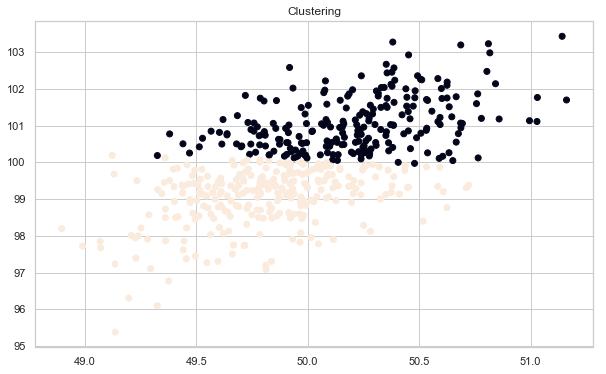

In [41]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.scatter(data["x1"], data["y"], c=y_pred)
axes.set_title("Clustering")

This shows the two clusters created with KMeans clustering. Essentially the data is split between ys greater than 100 and ys less than 100. 

1. With the data I did make up, there are no hidden clusters of data. The data shows a straight split of half the data being above 100 and below 100. This makes sense as the algorithm has to split the data in half some way without a specific categorical split.

2. Elbow Method

In [42]:
# From the following: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
Sum_of_squared_distances = []
ks = range(1,15)
for k in ks:
    km = KMeans(n_clusters=k)
    km = km.fit(data[["x1","y"]])
    Sum_of_squared_distances.append(km.inertia_)

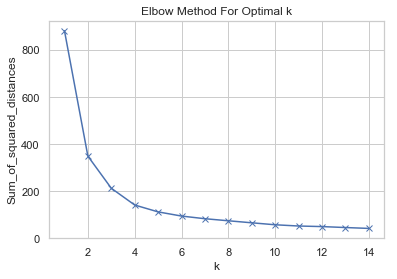

In [43]:
plt.plot(ks, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

This elbow plot shows deminishing returns at 4. So the best k would be 4 for this data set.

Text(0.5, 1.0, 'Clustering')

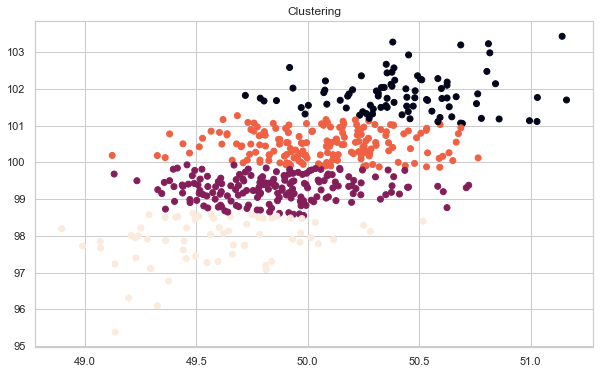

In [44]:
y_pred = KMeans(n_clusters=4).fit_predict(data[["x1","y"]])
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.scatter(data["x1"], data["y"], c=y_pred)
axes.set_title("Clustering")

2/3 Create data with clusters

In [45]:
np.random.seed([1643498156])

In [46]:
data = {}
data["x1"] = stats.norm.rvs(50.0, .4, 500)
p = .8
data["x2"] = np.array([1 if rand() < p else 0 for _ in range( 500)])
data["e"] = stats.norm.rvs(0, 1, 500)
data["y"] = data["x1"] * .5 + data["x2"] * 10 + data["e"]
data = pd.DataFrame(data)

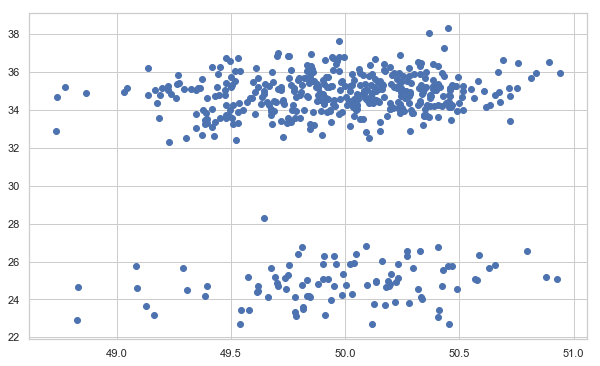

In [47]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data["x1"], data["y"])

In [48]:
Sum_of_squared_distances = []
ks = range(1,15)
for k in ks:
    km = KMeans(n_clusters=k)
    km = km.fit(data[["x1","y"]])
    Sum_of_squared_distances.append(km.inertia_)

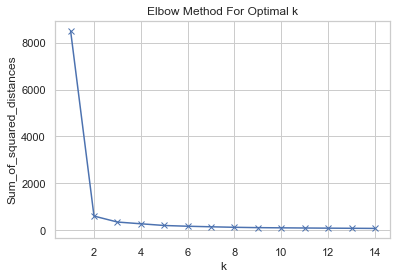

In [49]:
plt.plot(ks, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

With the two distinct clusters, this shows that k should clearly be two.

With very distint clusters, the k will be exact with the number of distinct clusters. When there are a either no hidden clusters or it's hard to tell if there are clusters that may have higher variance, the cluster number will be higher to be more specific.